In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt



In [15]:
# Define the Encoder model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        return x

# Define the Decoder model
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [16]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),                                      # Convert image to PyTorch tensor
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1), # Add Gaussian noise with sigma=0.1
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05),  # Apply random affine transformation
                             scale=(0.95, 1.05), shear=5),
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


In [17]:
# Function to add Gaussian noise to images
def add_gaussian_noise(images, sigma):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    return noisy_images

# Function to calculate SSIM
# Function to calculate SSIM
def calculate_ssim(img1, img2):
    img1 = img1.squeeze().detach().cpu().numpy()
    img2 = img2.squeeze().detach().cpu().numpy()
    return ssim(img1, img2, data_range=1)




In [18]:
# Training function
def train(model, criterion, optimizer, train_loader, sigma):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)  # Move images to device
        noisy_images = add_gaussian_noise(images, sigma)
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(train_loader.dataset)

# Testing function
def test(model, criterion, test_loader,sigma):
    model.eval()
    total_ssim = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)  # Move images to device
            noisy_images = add_gaussian_noise(images, sigma)  
            outputs = model(noisy_images)
            total_ssim += calculate_ssim(outputs, images)
    return total_ssim / len(test_loader)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)



In [19]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Training loop
epochs = 5
sigma_values = [0.1, 0.5, 1.0]  # Sigma values for Gaussian noise
ssim_scores = []

for sigma in sigma_values:
    print(f"Training with sigma = {sigma}")
    for epoch in range(epochs):
        train_loss = train(autoencoder, criterion, optimizer, train_loader, sigma)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    test_ssim = test(autoencoder, criterion, test_loader, sigma)
    ssim_scores.append(test_ssim)
    print(f"Average SSIM test score with sigma={sigma}: {test_ssim:.4f}")



Training with sigma = 0.1
Epoch 1/5, Train Loss: 0.0752
Epoch 2/5, Train Loss: 0.0499
Epoch 3/5, Train Loss: 0.0427
Epoch 4/5, Train Loss: 0.0382
Epoch 5/5, Train Loss: 0.0350
Average SSIM test score with sigma=0.1: 0.6924
Training with sigma = 0.5
Epoch 1/5, Train Loss: 0.0393
Epoch 2/5, Train Loss: 0.0377
Epoch 3/5, Train Loss: 0.0367
Epoch 4/5, Train Loss: 0.0359
Epoch 5/5, Train Loss: 0.0352
Average SSIM test score with sigma=0.5: 0.6827
Training with sigma = 1.0
Epoch 1/5, Train Loss: 0.0466
Epoch 2/5, Train Loss: 0.0457
Epoch 3/5, Train Loss: 0.0453
Epoch 4/5, Train Loss: 0.0451
Epoch 5/5, Train Loss: 0.0448
Average SSIM test score with sigma=1.0: 0.5840


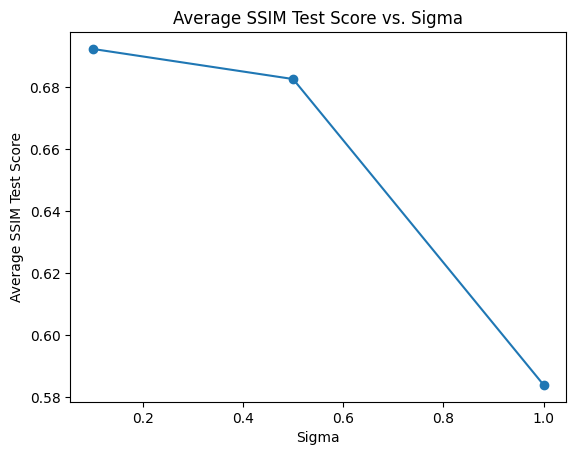

In [20]:
# Plot SSIM scores
plt.plot(sigma_values, ssim_scores, marker='o')
plt.title('Average SSIM Test Score vs. Sigma')
plt.xlabel('Sigma')
plt.ylabel('Average SSIM Test Score')
plt.show()


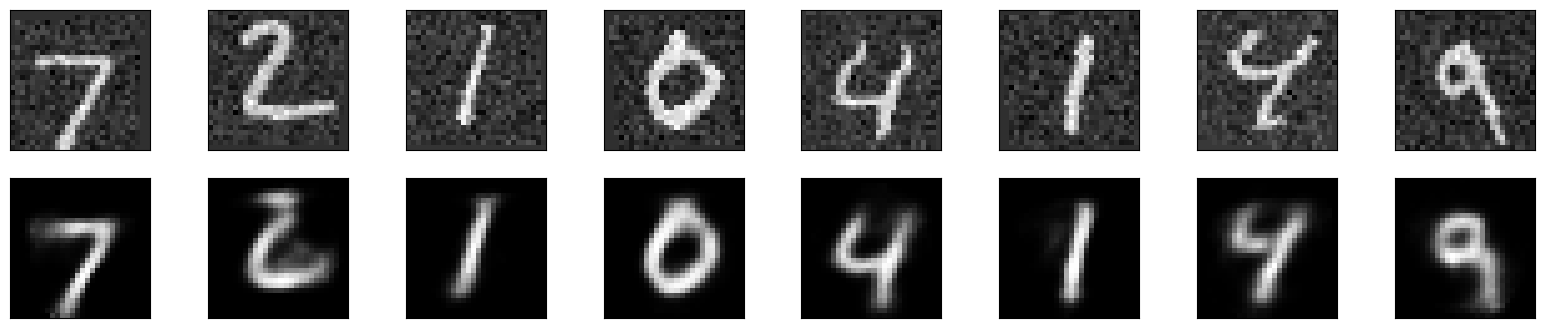

In [21]:
# Show actual and predicted images
images, _ = next(iter(test_loader))
images = images.to(device)  # Move images to the same device as the model
outputs = autoencoder(images)
n = min(images.size(0), 8)
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i][0].detach().cpu().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i][0].detach().cpu().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [22]:
import matplotlib.pyplot as plt

def test(model, criterion, test_loader , sigma):
    model.eval()
    total_ssim = 0.0
    all_actual_images = []
    all_noisy_images = []
    all_predicted_images = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)  # Move images to device
            noisy_images = add_gaussian_noise(images, sigma)  
            outputs = model(noisy_images)
            total_ssim += calculate_ssim(outputs, images)
            all_actual_images.append(images.cpu())
            all_noisy_images.append(noisy_images.cpu())
            all_predicted_images.append(outputs.cpu())
    all_actual_images = torch.cat(all_actual_images, dim=0)
    all_noisy_images = torch.cat(all_noisy_images, dim=0)
    all_predicted_images = torch.cat(all_predicted_images, dim=0)
    return total_ssim / len(test_loader), all_actual_images, all_noisy_images, all_predicted_images




Training with sigma = 0.1
Epoch 1/5, Train Loss: 0.0290
Epoch 2/5, Train Loss: 0.0275
Epoch 3/5, Train Loss: 0.0269
Epoch 4/5, Train Loss: 0.0265
Epoch 5/5, Train Loss: 0.0261
Average SSIM test score with sigma=0.1: 0.7594


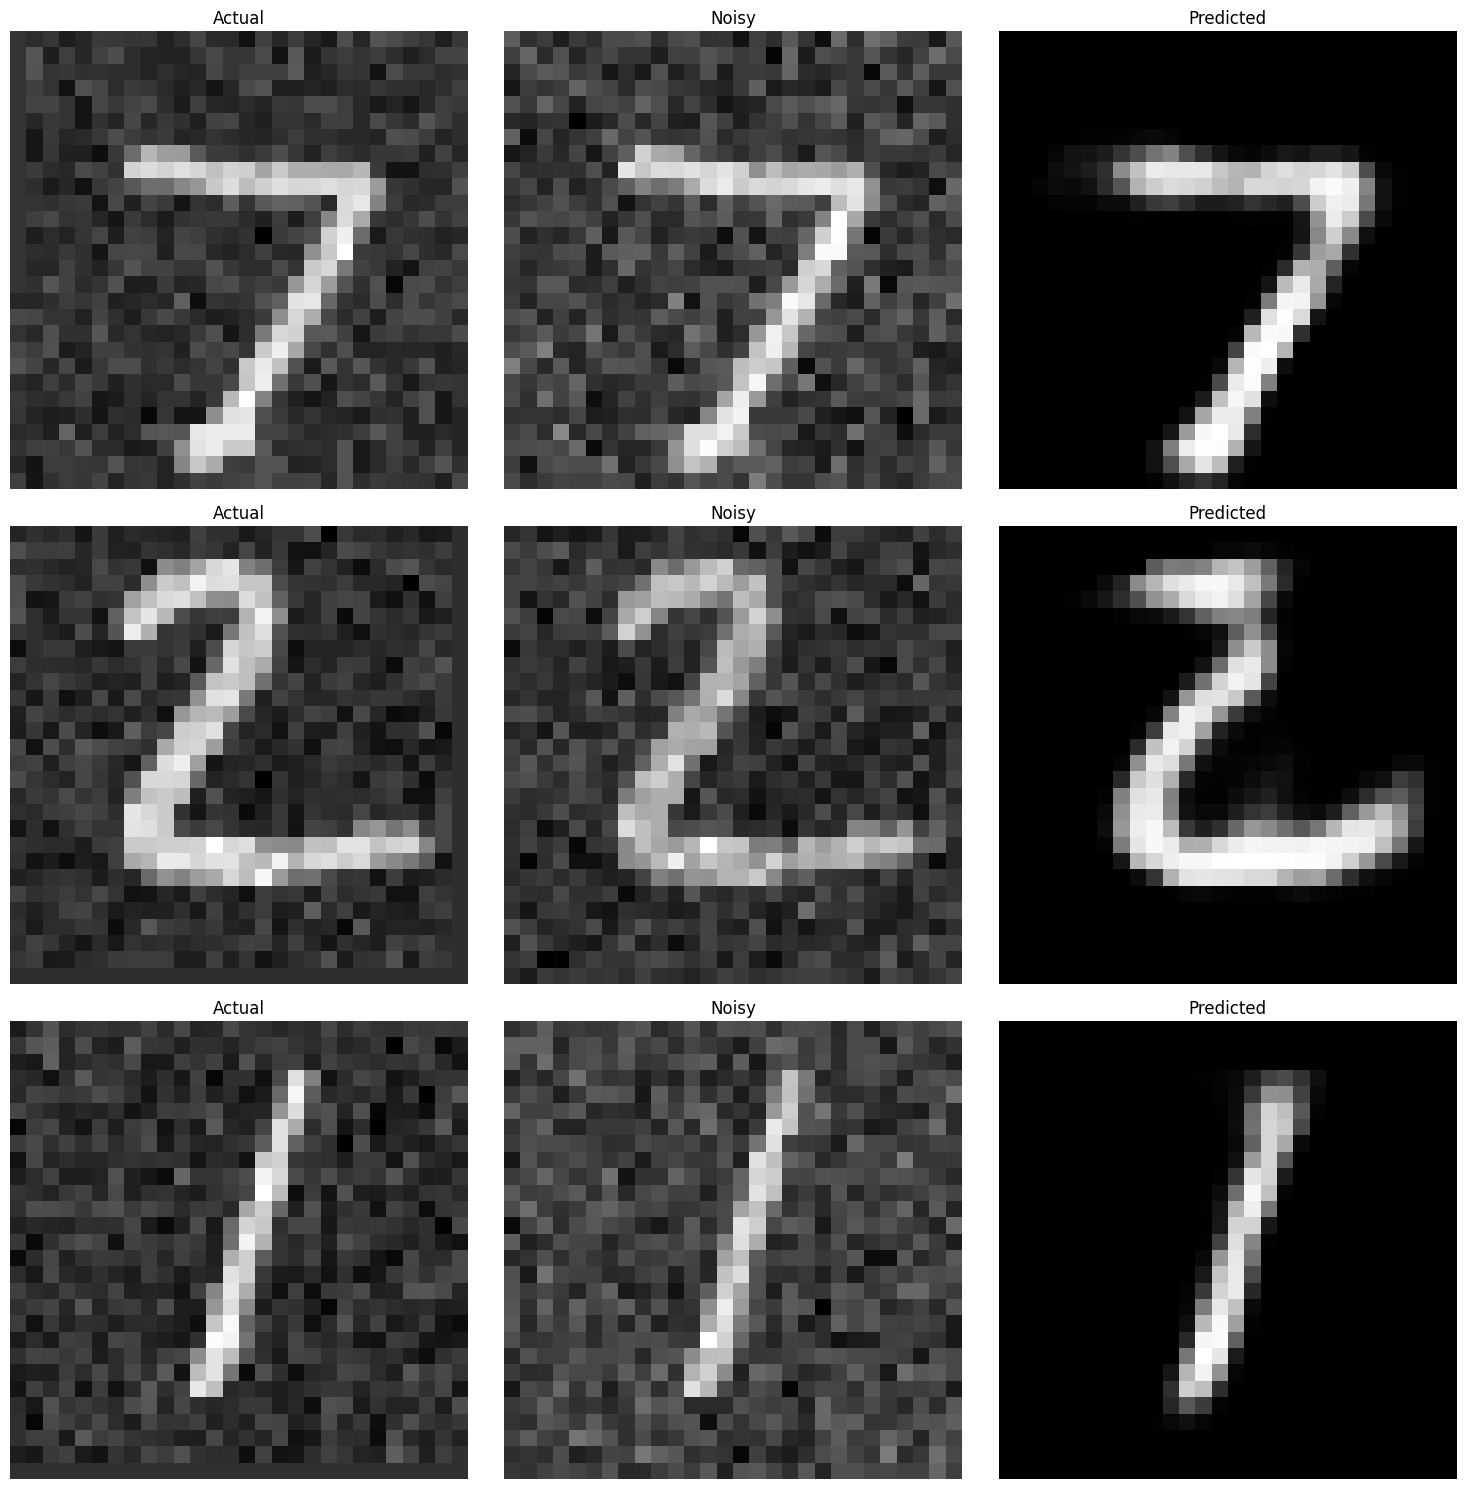

Training with sigma = 0.5
Epoch 1/5, Train Loss: 0.0329
Epoch 2/5, Train Loss: 0.0324
Epoch 3/5, Train Loss: 0.0322
Epoch 4/5, Train Loss: 0.0320
Epoch 5/5, Train Loss: 0.0319
Average SSIM test score with sigma=0.5: 0.7073


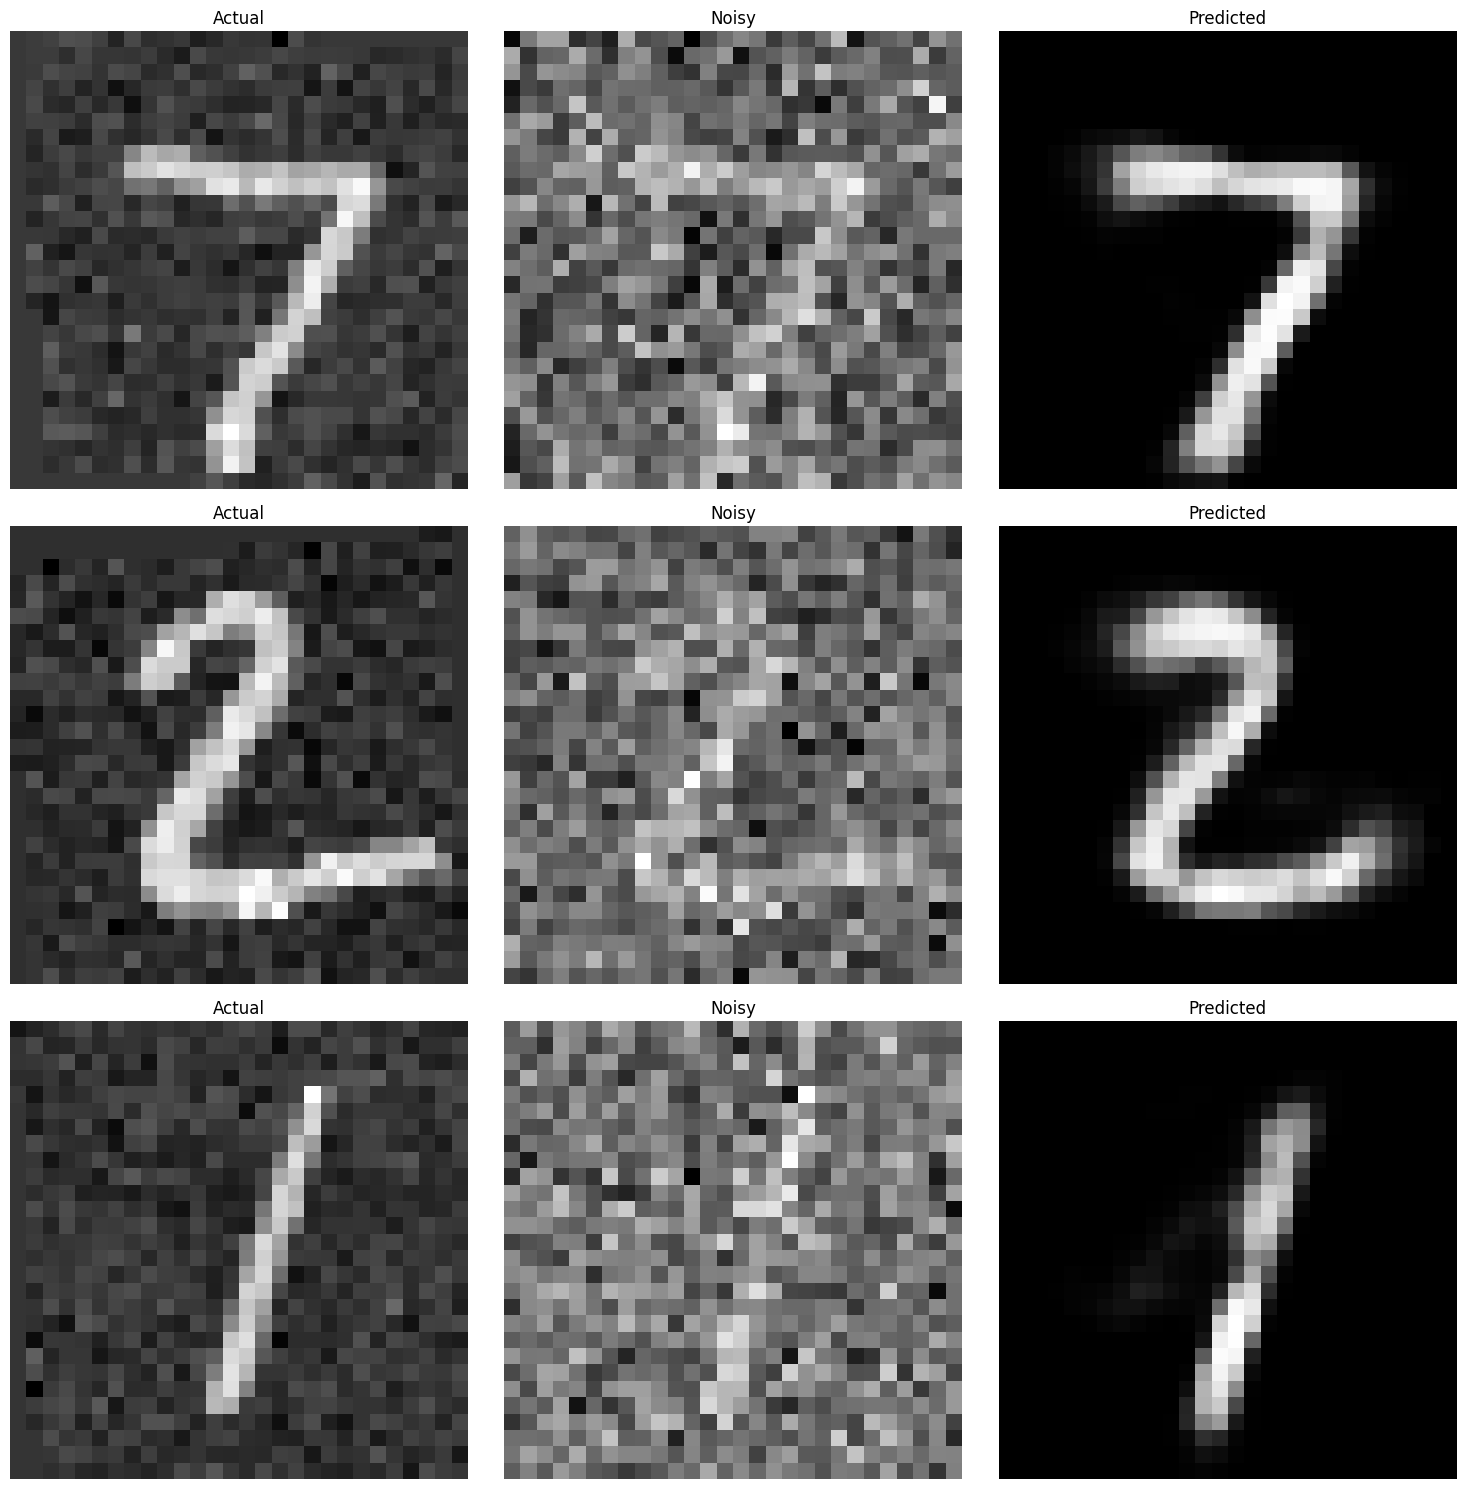

Training with sigma = 1.0
Epoch 1/5, Train Loss: 0.0445
Epoch 2/5, Train Loss: 0.0438
Epoch 3/5, Train Loss: 0.0435
Epoch 4/5, Train Loss: 0.0433
Epoch 5/5, Train Loss: 0.0432
Average SSIM test score with sigma=1.0: 0.6014


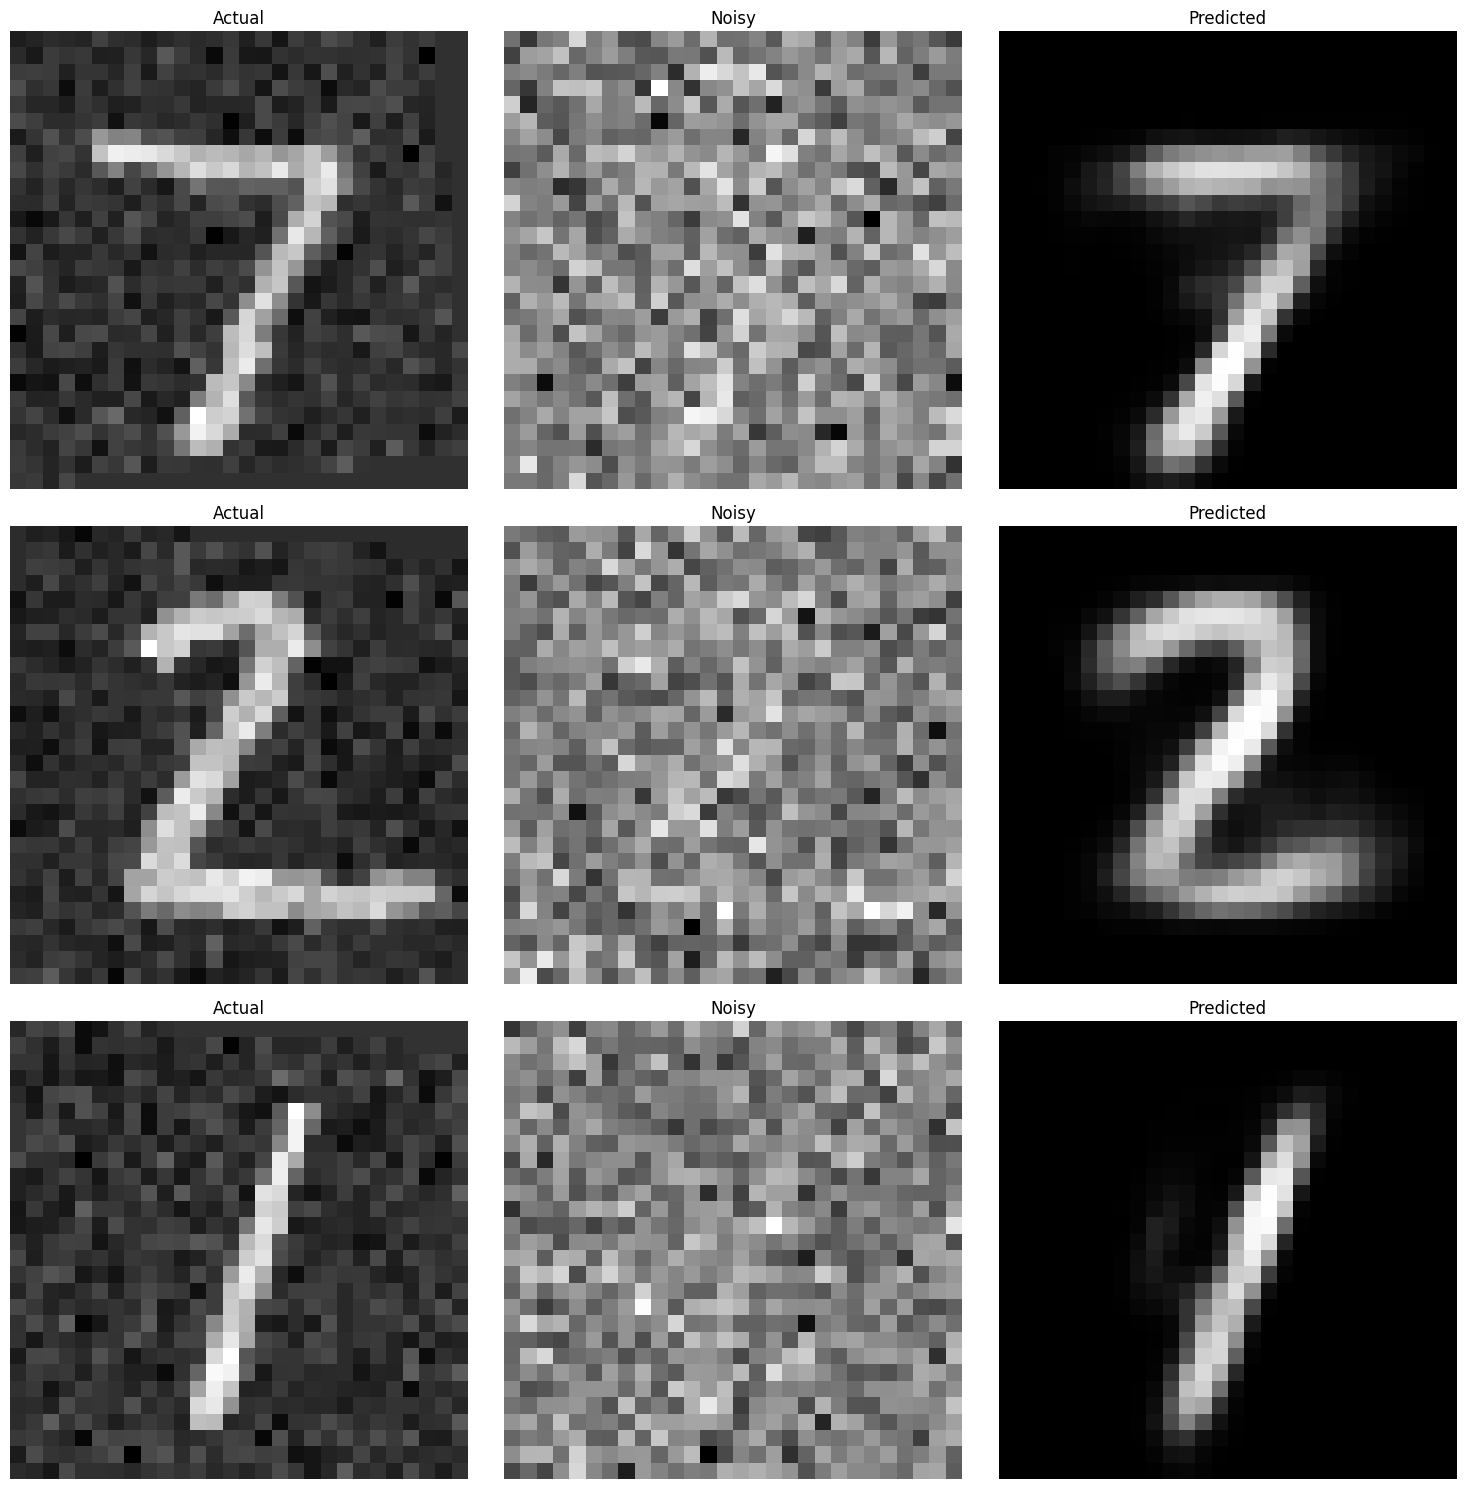

In [23]:
# Training loop
epochs = 5
sigma_values = [0.1, 0.5, 1.0]  # Sigma values for Gaussian noise
ssim_scores = []

for sigma in sigma_values:
    print(f"Training with sigma = {sigma}")
    for epoch in range(epochs):
        train_loss = train(autoencoder, criterion, optimizer, train_loader, sigma)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    test_ssim, actual_images, noisy_images, predicted_images = test(autoencoder, criterion, test_loader , sigma)
    ssim_scores.append(test_ssim)
    print(f"Average SSIM test score with sigma={sigma}: {test_ssim:.4f}")

    # Plotting some example images
    num_examples = 3
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 15))
    for i in range(num_examples):
        axes[i, 0].imshow(actual_images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title("Actual")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(noisy_images[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Noisy")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predicted_images[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Predicted")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

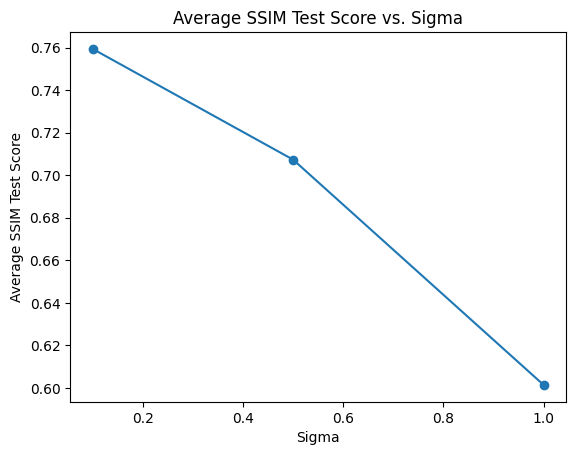

In [24]:
# Plot SSIM scores
plt.plot(sigma_values, ssim_scores, marker='o')
plt.title('Average SSIM Test Score vs. Sigma')
plt.xlabel('Sigma')
plt.ylabel('Average SSIM Test Score')
plt.show()


Sigma Constant =0.1
change BottleNeck = 16,32,64

Training with Sigma Constant = 0.1
Training with bottleneck dimension = 16
Epoch 1/5, Train Loss: 0.0757
Epoch 2/5, Train Loss: 0.0477
Epoch 3/5, Train Loss: 0.0408
Epoch 4/5, Train Loss: 0.0369
Epoch 5/5, Train Loss: 0.0344
Average SSIM test score with bottleneck dimension=16: 0.6983


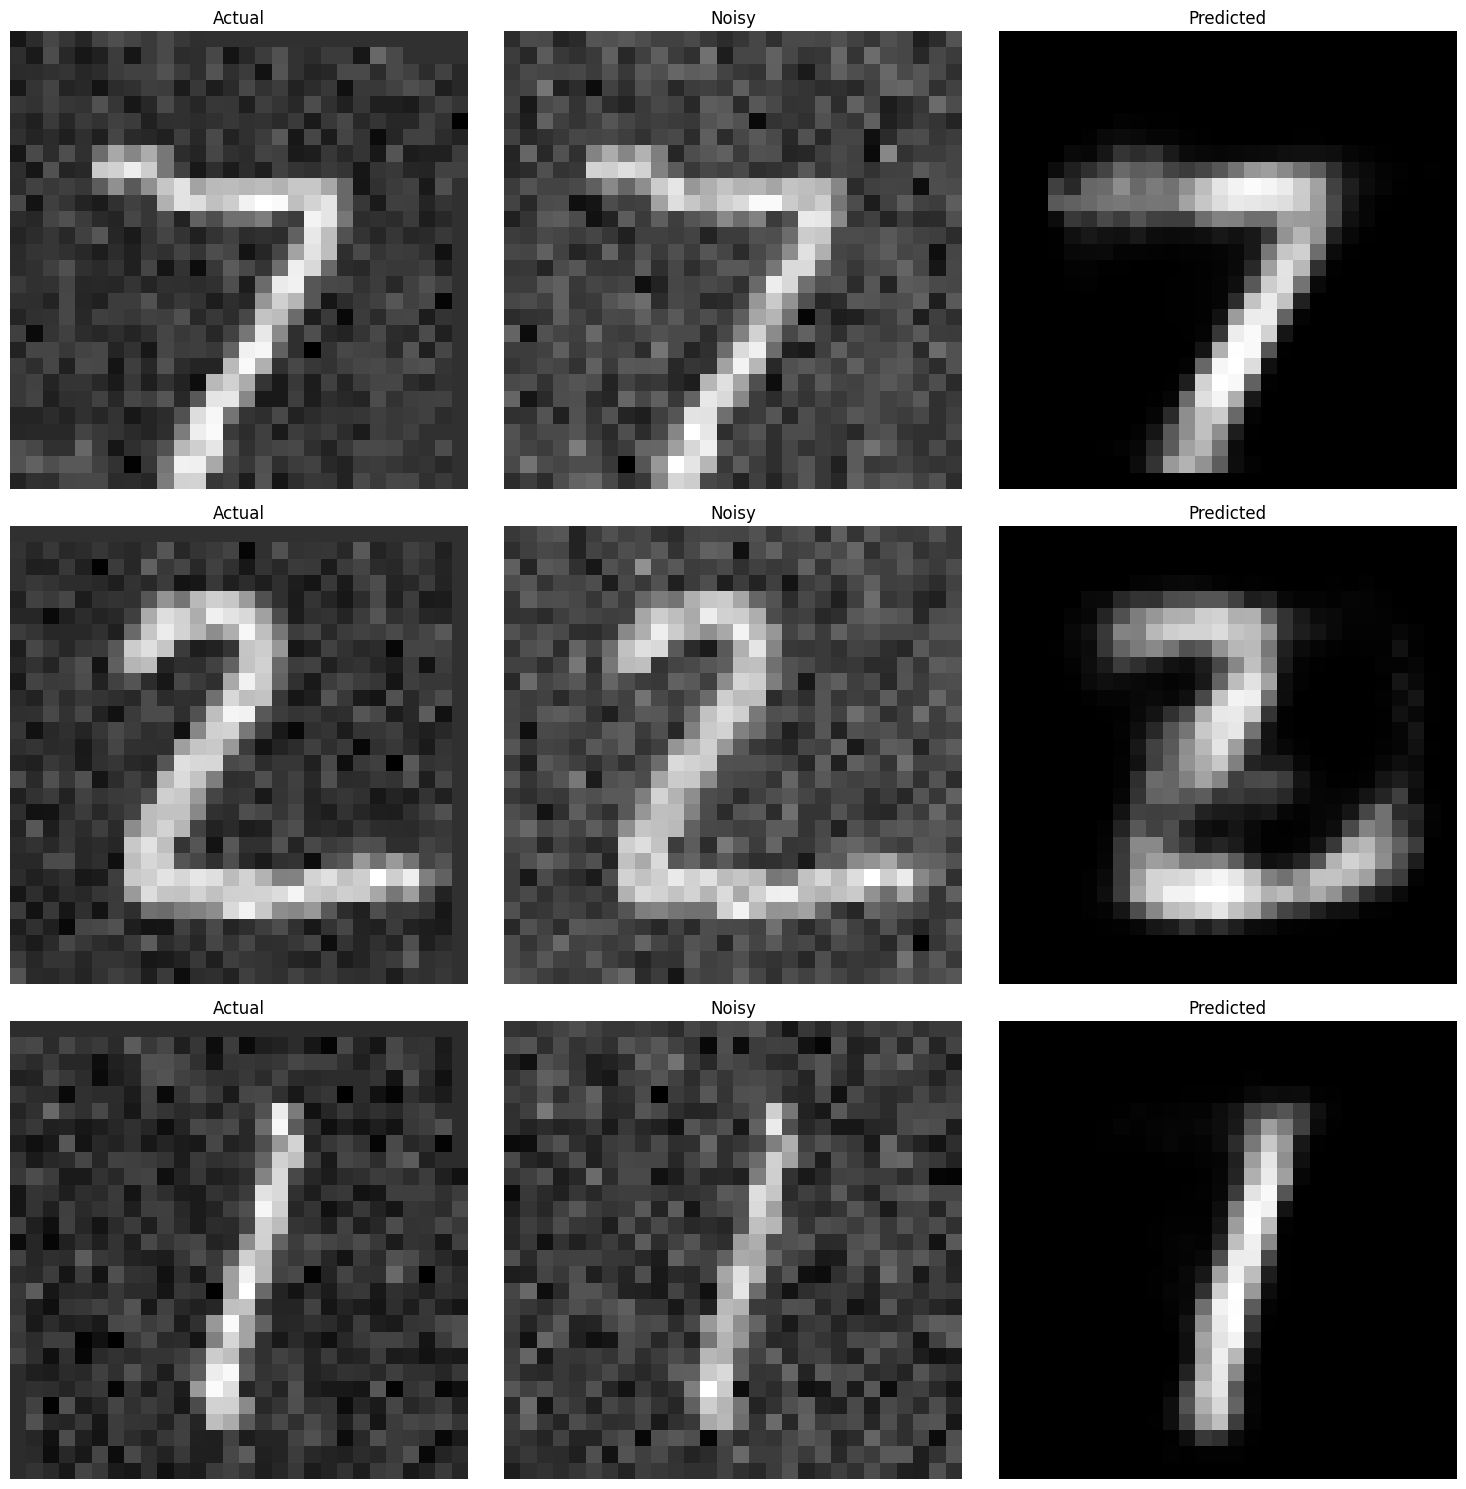

Training with bottleneck dimension = 32
Epoch 1/5, Train Loss: 0.0326
Epoch 2/5, Train Loss: 0.0313
Epoch 3/5, Train Loss: 0.0303
Epoch 4/5, Train Loss: 0.0294
Epoch 5/5, Train Loss: 0.0285
Average SSIM test score with bottleneck dimension=32: 0.7408


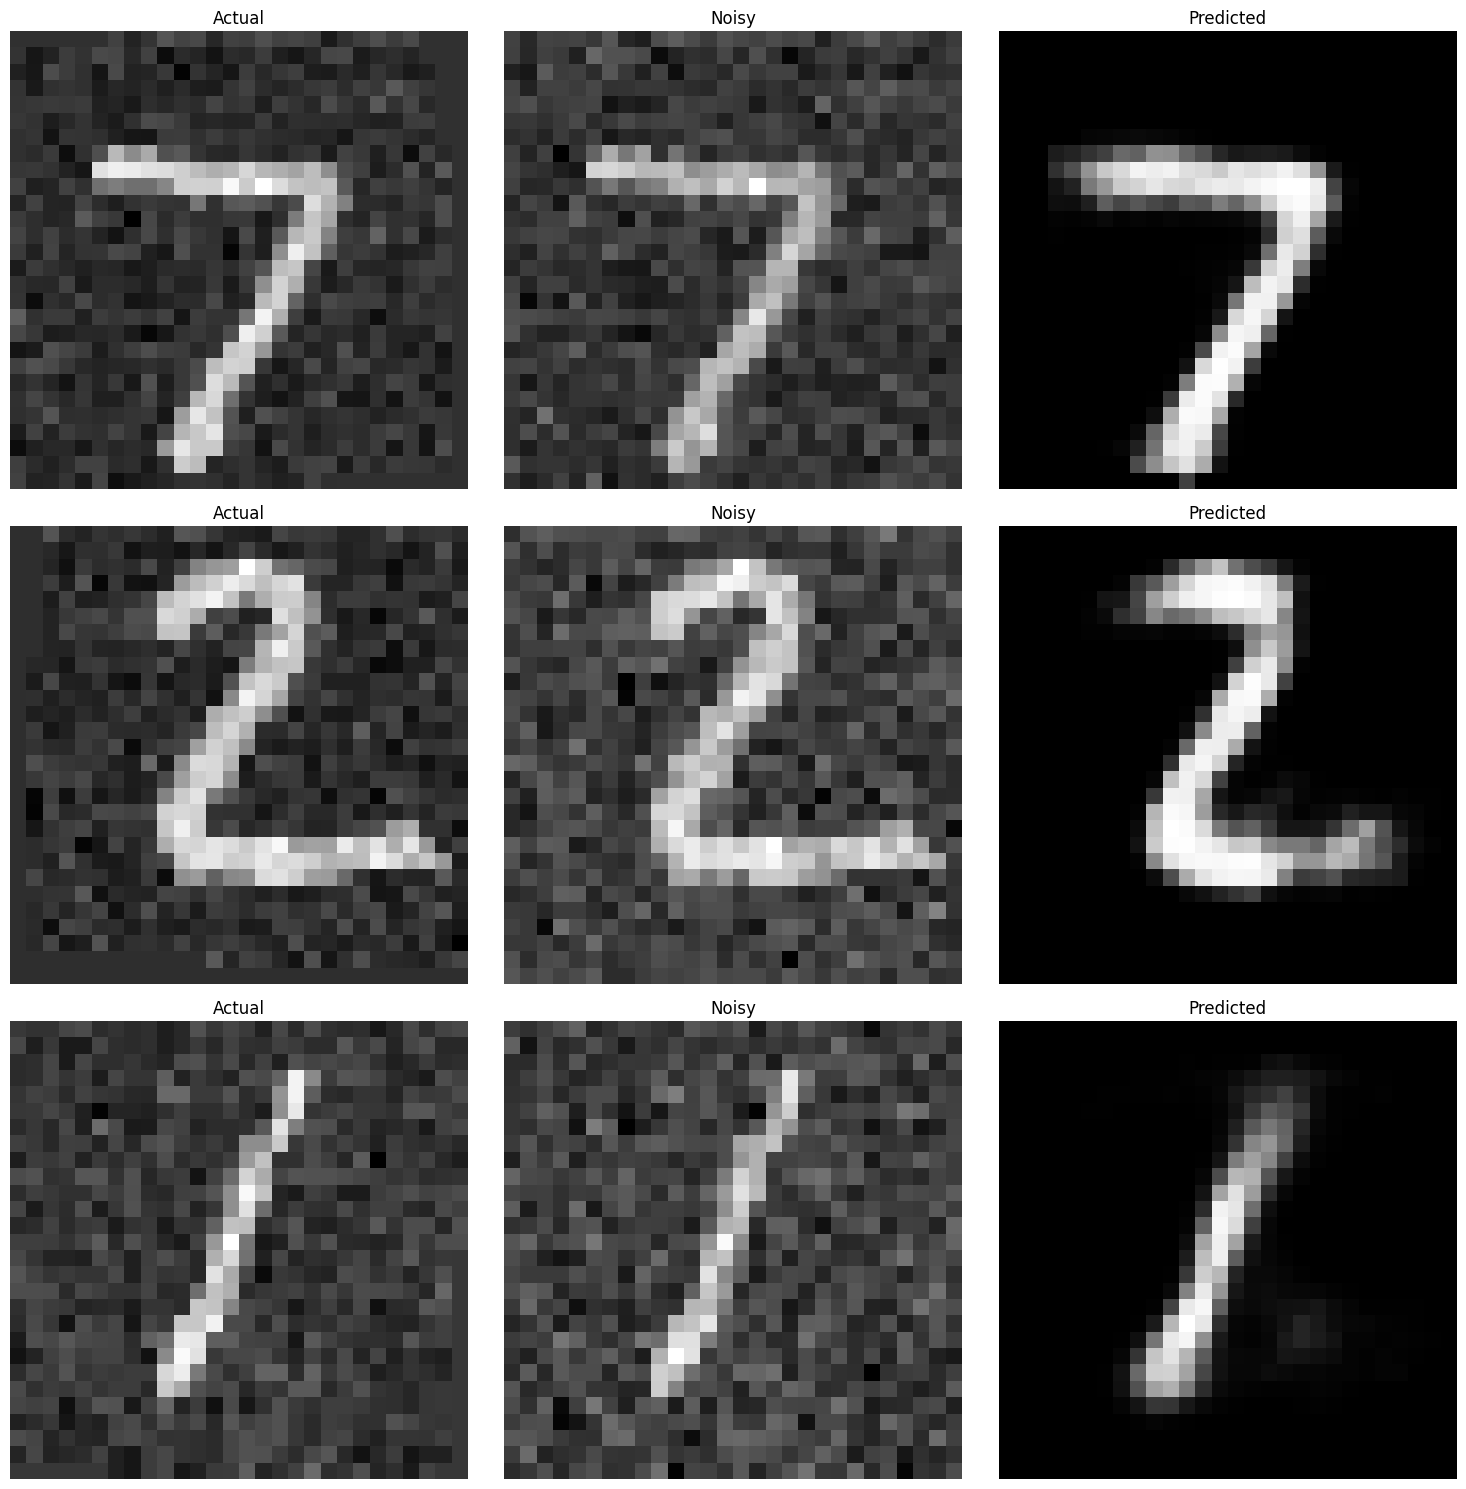

Training with bottleneck dimension = 64
Epoch 1/5, Train Loss: 0.0277
Epoch 2/5, Train Loss: 0.0270
Epoch 3/5, Train Loss: 0.0265
Epoch 4/5, Train Loss: 0.0260
Epoch 5/5, Train Loss: 0.0256
Average SSIM test score with bottleneck dimension=64: 0.7657


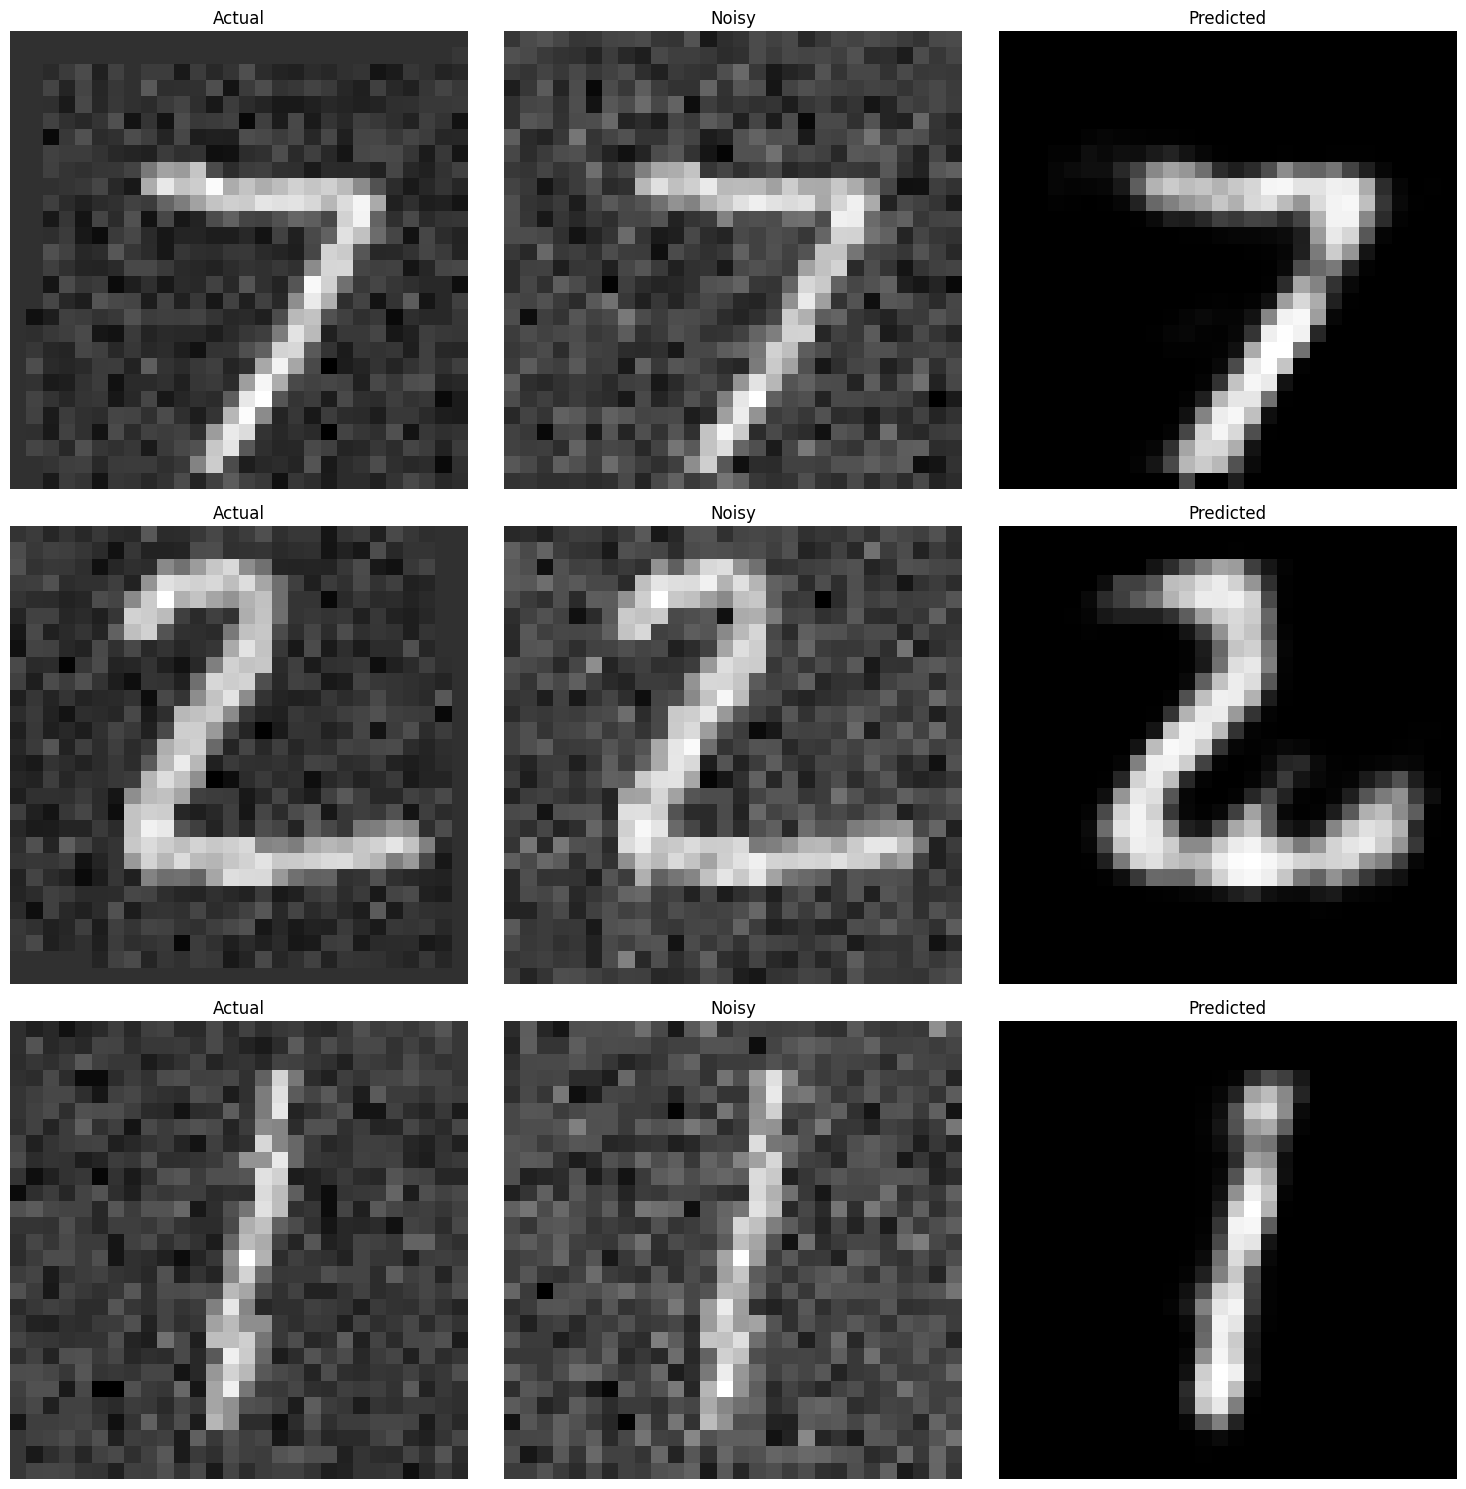

In [27]:

# Training loop
epochs = 5
sigma = 0.1  # Set sigma constant
bottleneck_dims = [16, 32, 64]  # Bottleneck dimensions for the model
ssim_scores_bottleneck = []

print(f"Training with Sigma Constant = {sigma}")

# Initialize model, criterion, optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)



for bottleneck_dim in bottleneck_dims:
    print(f"Training with bottleneck dimension = {bottleneck_dim}")
    for epoch in range(epochs):
        train_loss = train(autoencoder, criterion, optimizer, train_loader, sigma)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    test_ssim, actual_images, noisy_images, predicted_images = test(autoencoder, criterion, test_loader , sigma)
    ssim_scores_bottleneck.append(test_ssim)
    print(f"Average SSIM test score with bottleneck dimension={bottleneck_dim}: {test_ssim:.4f}")


    num_examples = 3
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 15))
    for i in range(num_examples):
        axes[i, 0].imshow(actual_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 0].set_title("Actual")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(noisy_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 1].set_title("Noisy")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predicted_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 2].set_title("Predicted")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()




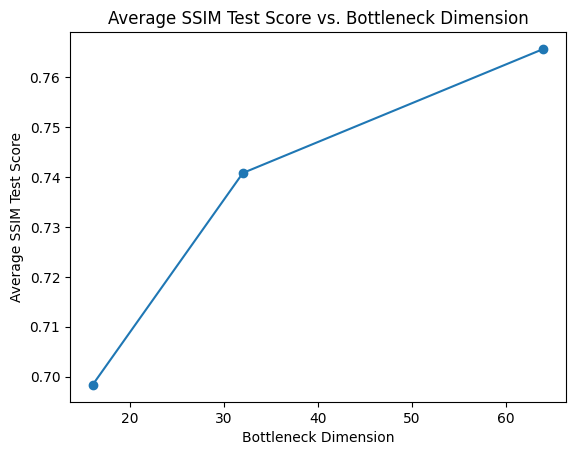

In [28]:
# Plot SSIM scores for different bottleneck dimensions
plt.plot(bottleneck_dims, ssim_scores_bottleneck, marker='o')
plt.title('Average SSIM Test Score vs. Bottleneck Dimension')
plt.xlabel('Bottleneck Dimension')
plt.ylabel('Average SSIM Test Score')
plt.show()

Training with Sigma Constant = 0.5
Training with bottleneck dimension = 16
Epoch 1/5, Train Loss: 0.0776
Epoch 2/5, Train Loss: 0.0508
Epoch 3/5, Train Loss: 0.0447
Epoch 4/5, Train Loss: 0.0419
Epoch 5/5, Train Loss: 0.0399
Average SSIM test score with bottleneck dimension=16: 0.6395


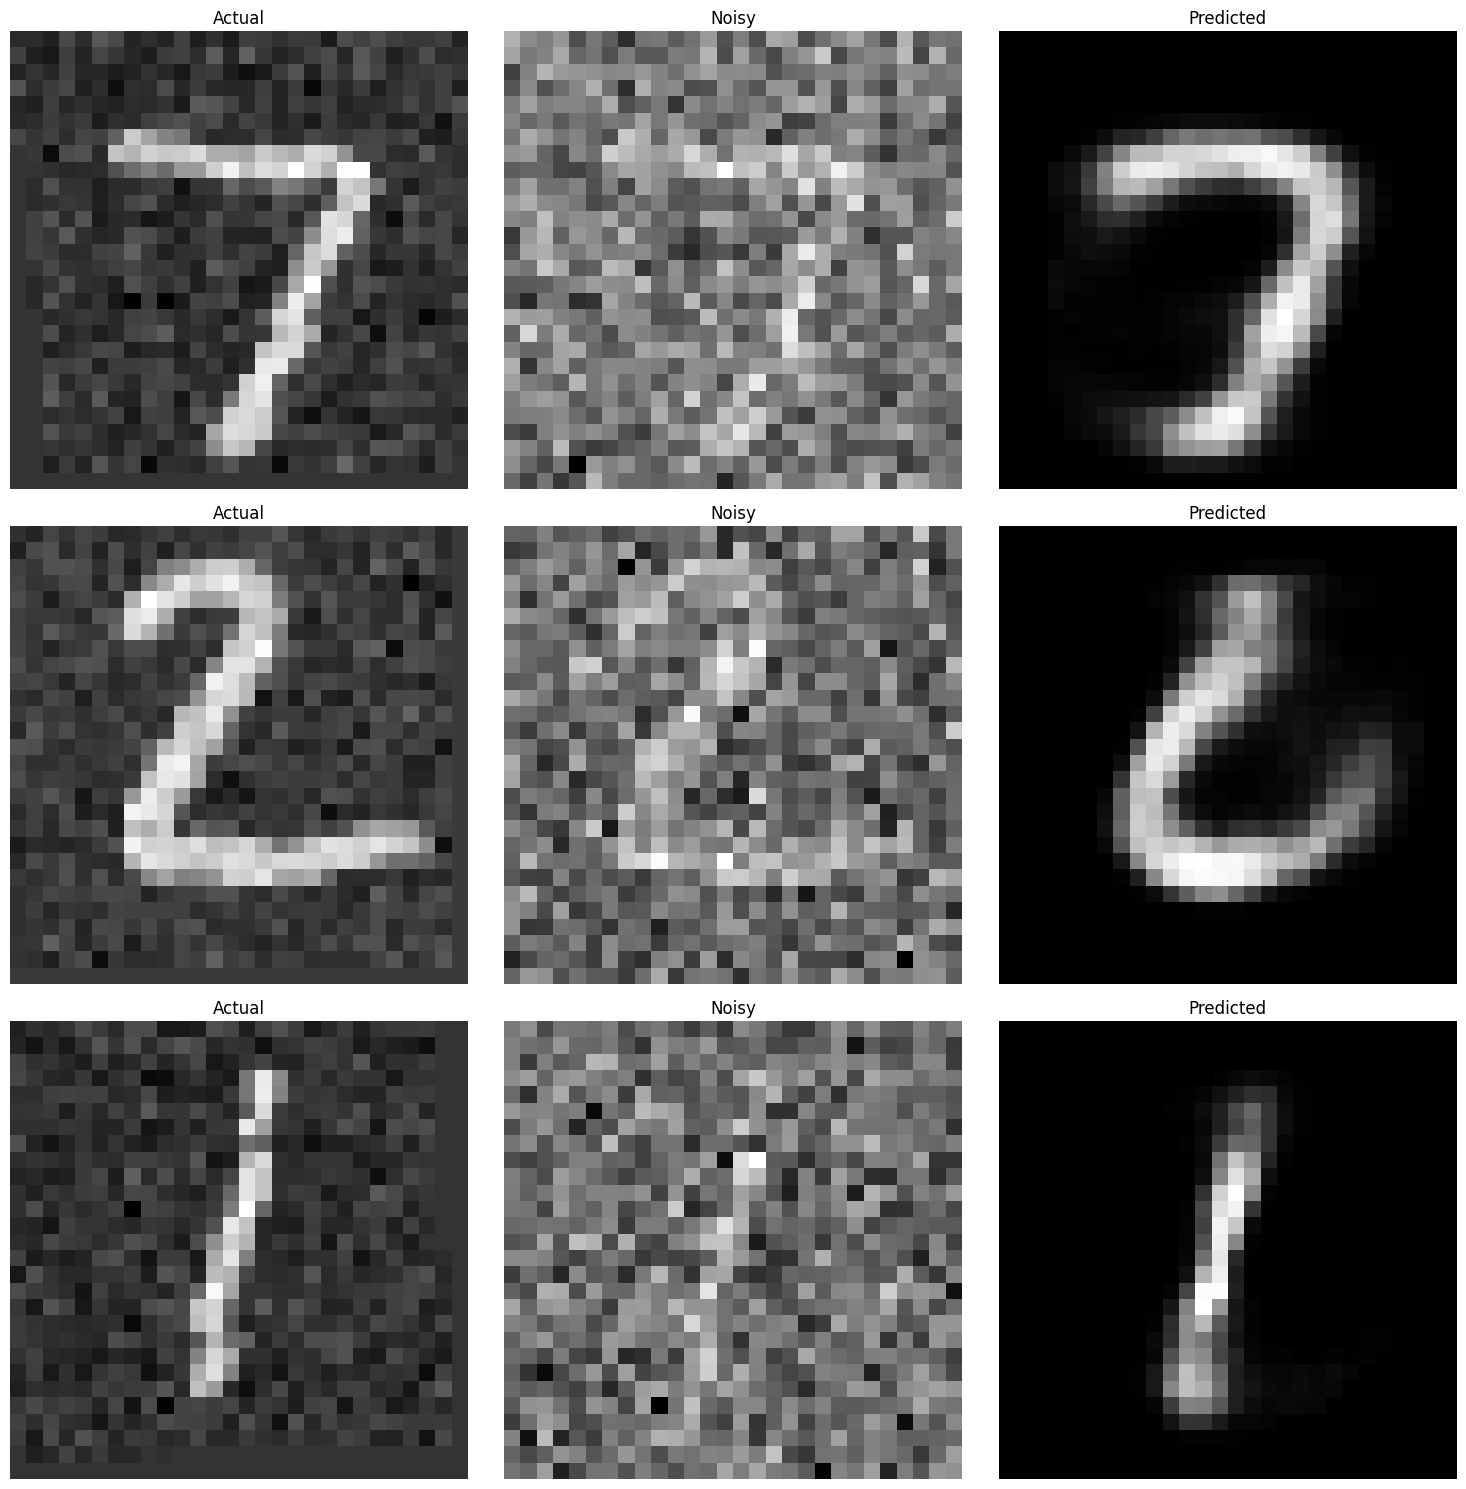

Training with bottleneck dimension = 32
Epoch 1/5, Train Loss: 0.0381
Epoch 2/5, Train Loss: 0.0368
Epoch 3/5, Train Loss: 0.0357
Epoch 4/5, Train Loss: 0.0348
Epoch 5/5, Train Loss: 0.0339
Average SSIM test score with bottleneck dimension=32: 0.6917


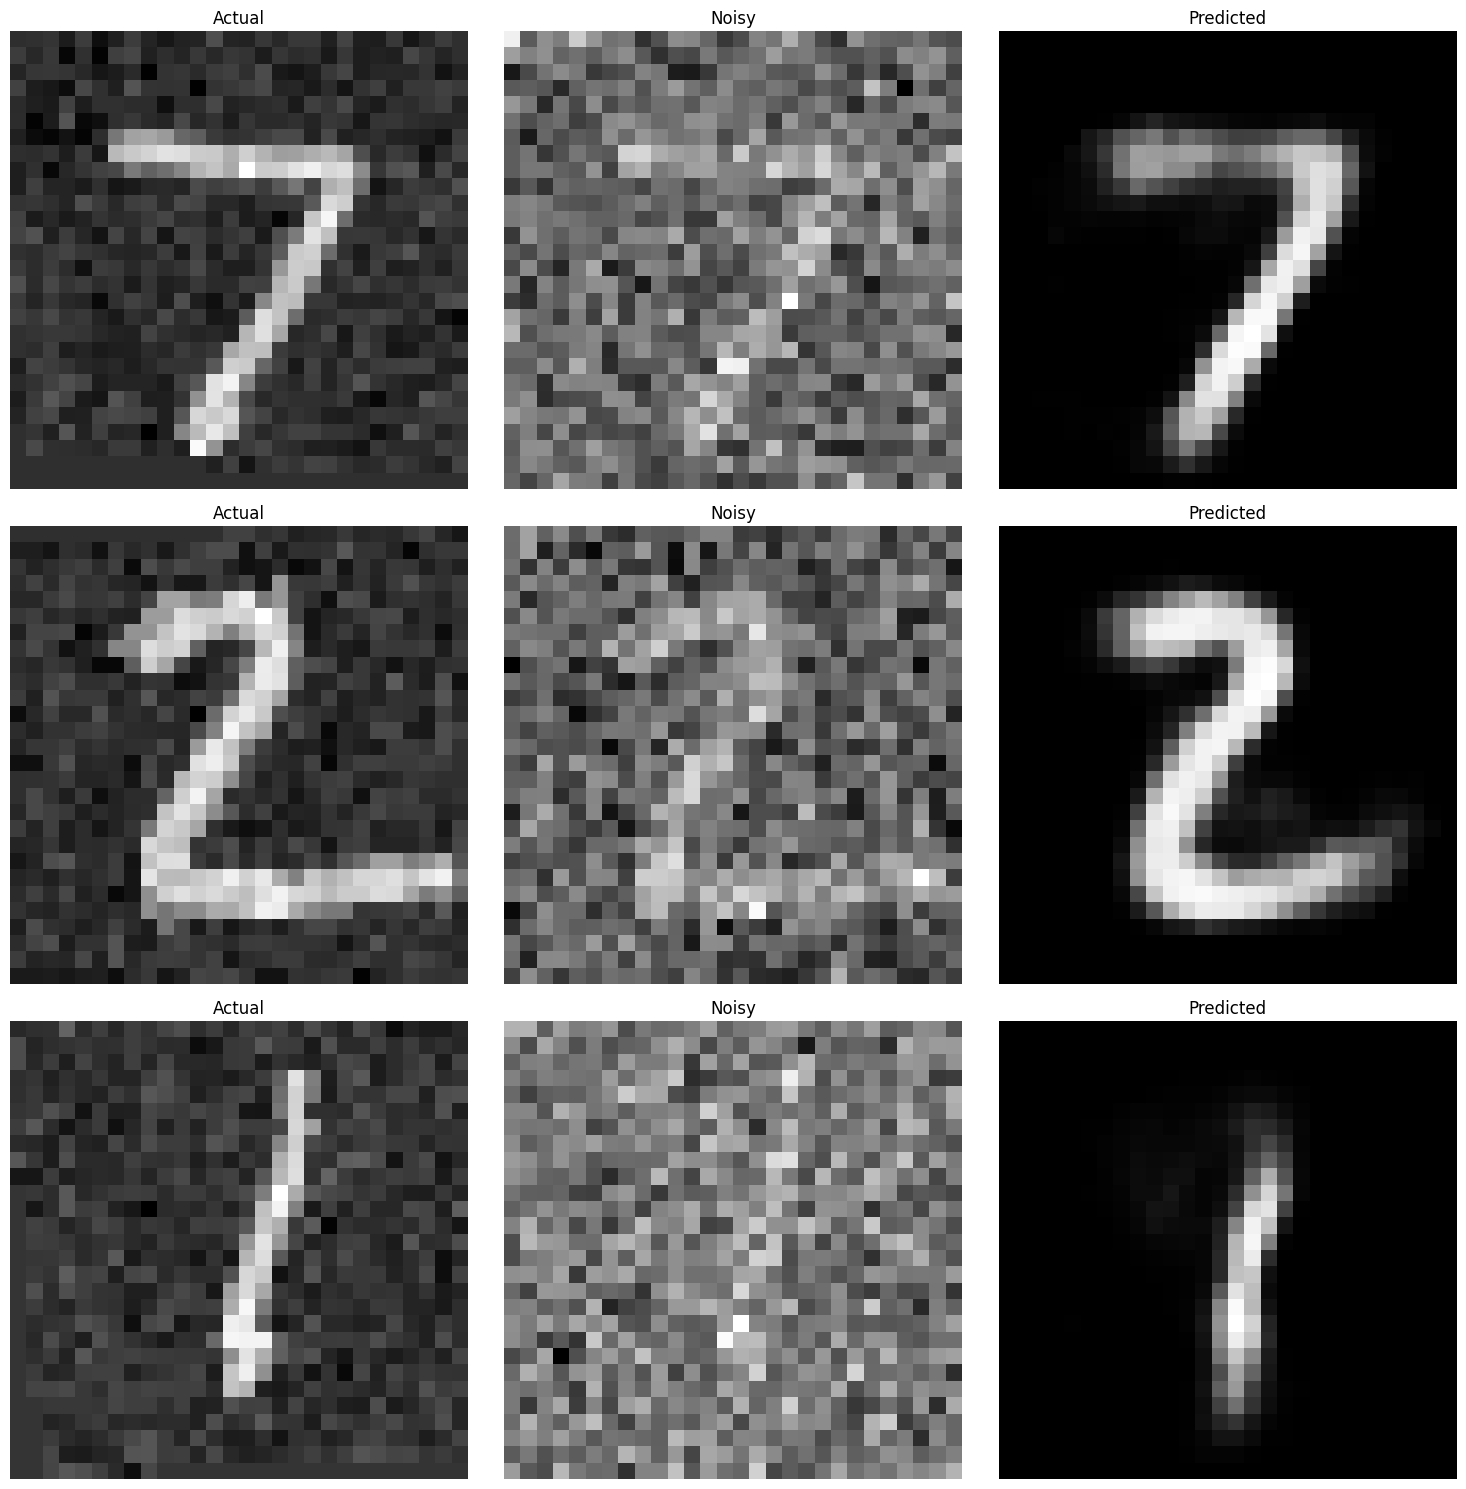

Training with bottleneck dimension = 64
Epoch 1/5, Train Loss: 0.0333
Epoch 2/5, Train Loss: 0.0328
Epoch 3/5, Train Loss: 0.0323
Epoch 4/5, Train Loss: 0.0320
Epoch 5/5, Train Loss: 0.0317
Average SSIM test score with bottleneck dimension=64: 0.7085


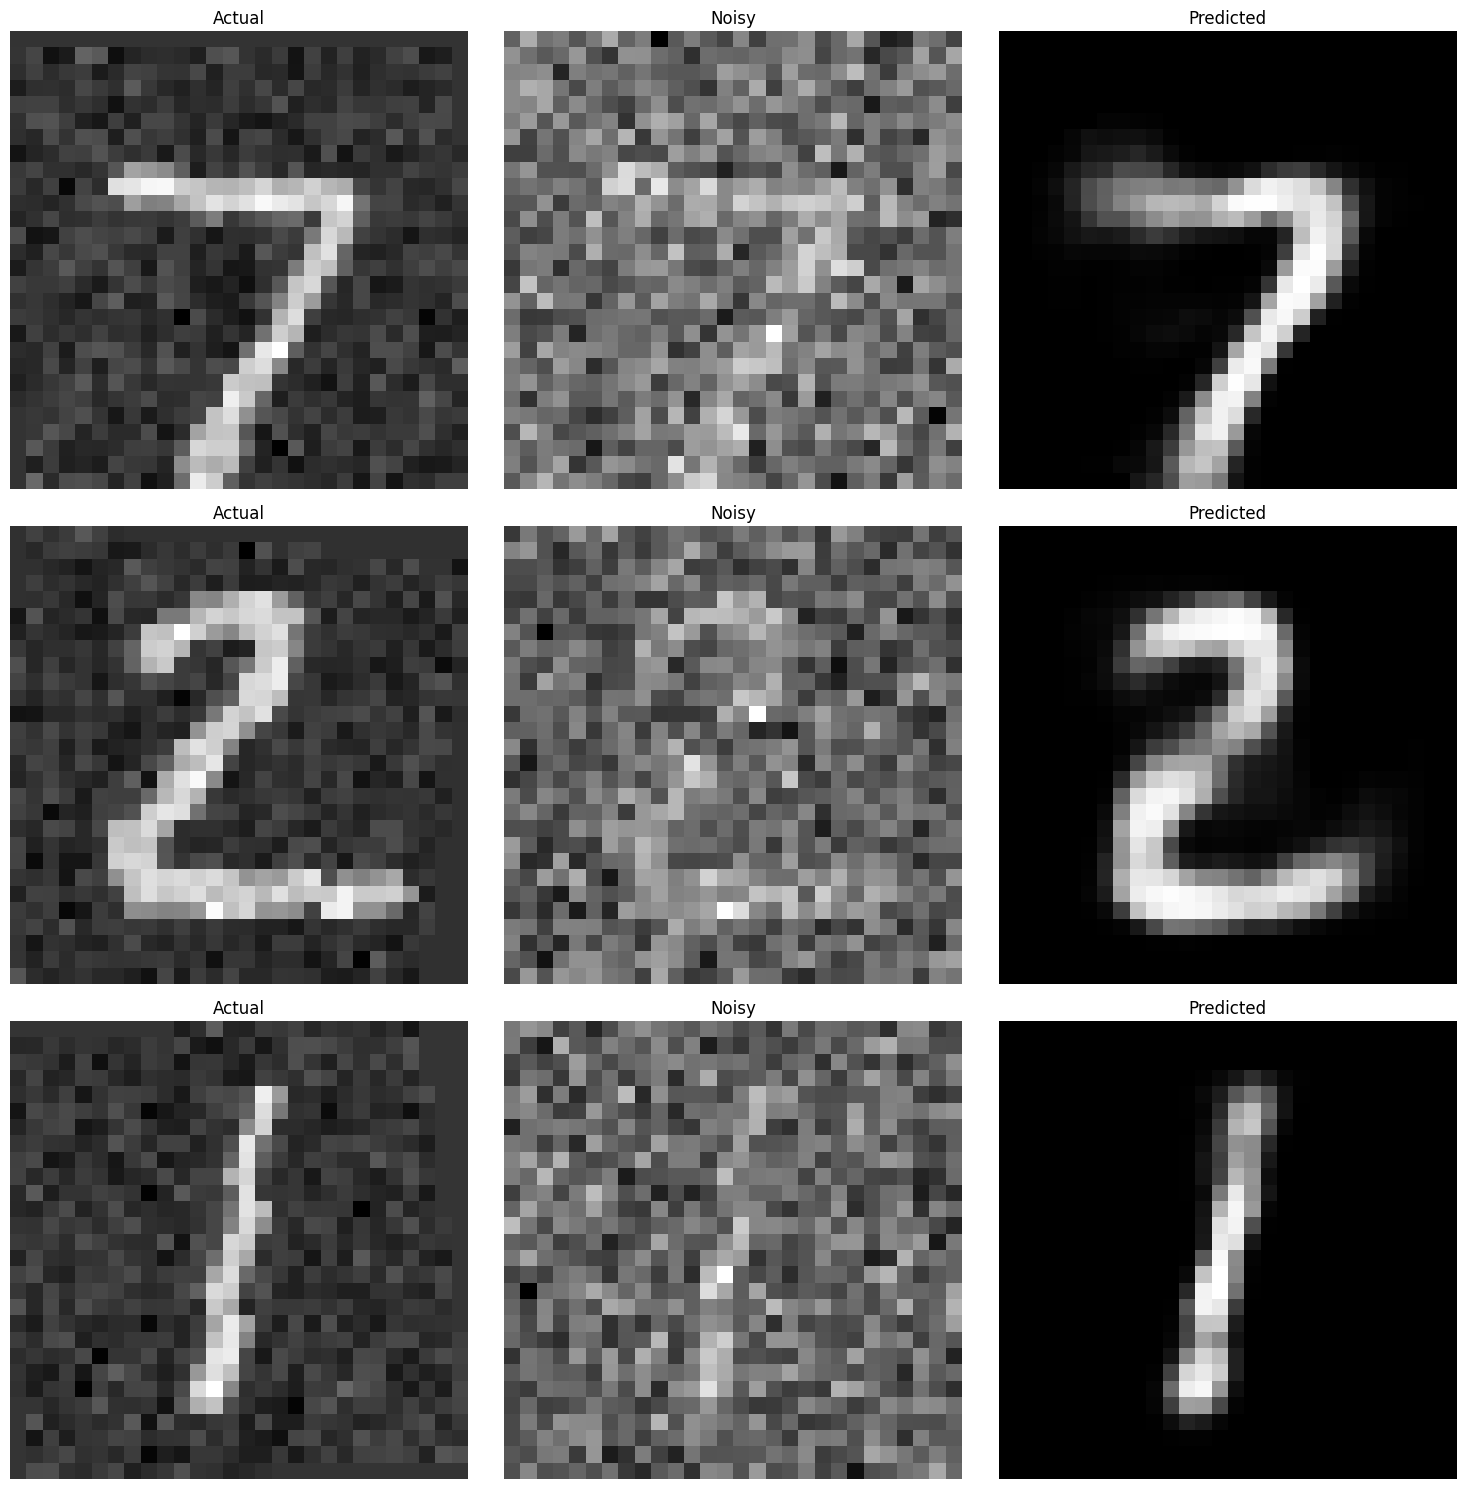

In [29]:

# Training loop
epochs = 5
sigma = 0.5  # Set sigma constant
bottleneck_dims = [16, 32, 64]  # Bottleneck dimensions for the model
ssim_scores_bottleneck = []

print(f"Training with Sigma Constant = {sigma}")

# Initialize model, criterion, optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)



for bottleneck_dim in bottleneck_dims:
    print(f"Training with bottleneck dimension = {bottleneck_dim}")
    for epoch in range(epochs):
        train_loss = train(autoencoder, criterion, optimizer, train_loader, sigma)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    test_ssim, actual_images, noisy_images, predicted_images = test(autoencoder, criterion, test_loader , sigma)

    ssim_scores_bottleneck.append(test_ssim)
    print(f"Average SSIM test score with bottleneck dimension={bottleneck_dim}: {test_ssim:.4f}")


    num_examples = 3
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 15))
    for i in range(num_examples):
        axes[i, 0].imshow(actual_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 0].set_title("Actual")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(noisy_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 1].set_title("Noisy")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predicted_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 2].set_title("Predicted")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()




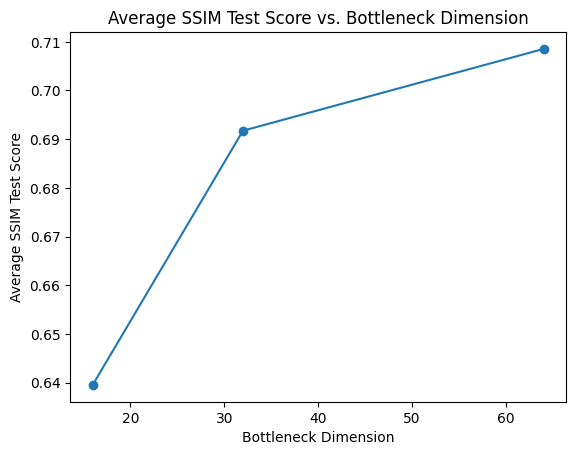

In [30]:
# Plot SSIM scores for different bottleneck dimensions
plt.plot(bottleneck_dims, ssim_scores_bottleneck, marker='o')
plt.title('Average SSIM Test Score vs. Bottleneck Dimension')
plt.xlabel('Bottleneck Dimension')
plt.ylabel('Average SSIM Test Score')
plt.show()

Training with Sigma Constant = 1.0
Training with bottleneck dimension = 16
Epoch 1/5, Train Loss: 0.0794
Epoch 2/5, Train Loss: 0.0599
Epoch 3/5, Train Loss: 0.0544
Epoch 4/5, Train Loss: 0.0516
Epoch 5/5, Train Loss: 0.0496
Average SSIM test score with bottleneck dimension=16: 0.5418


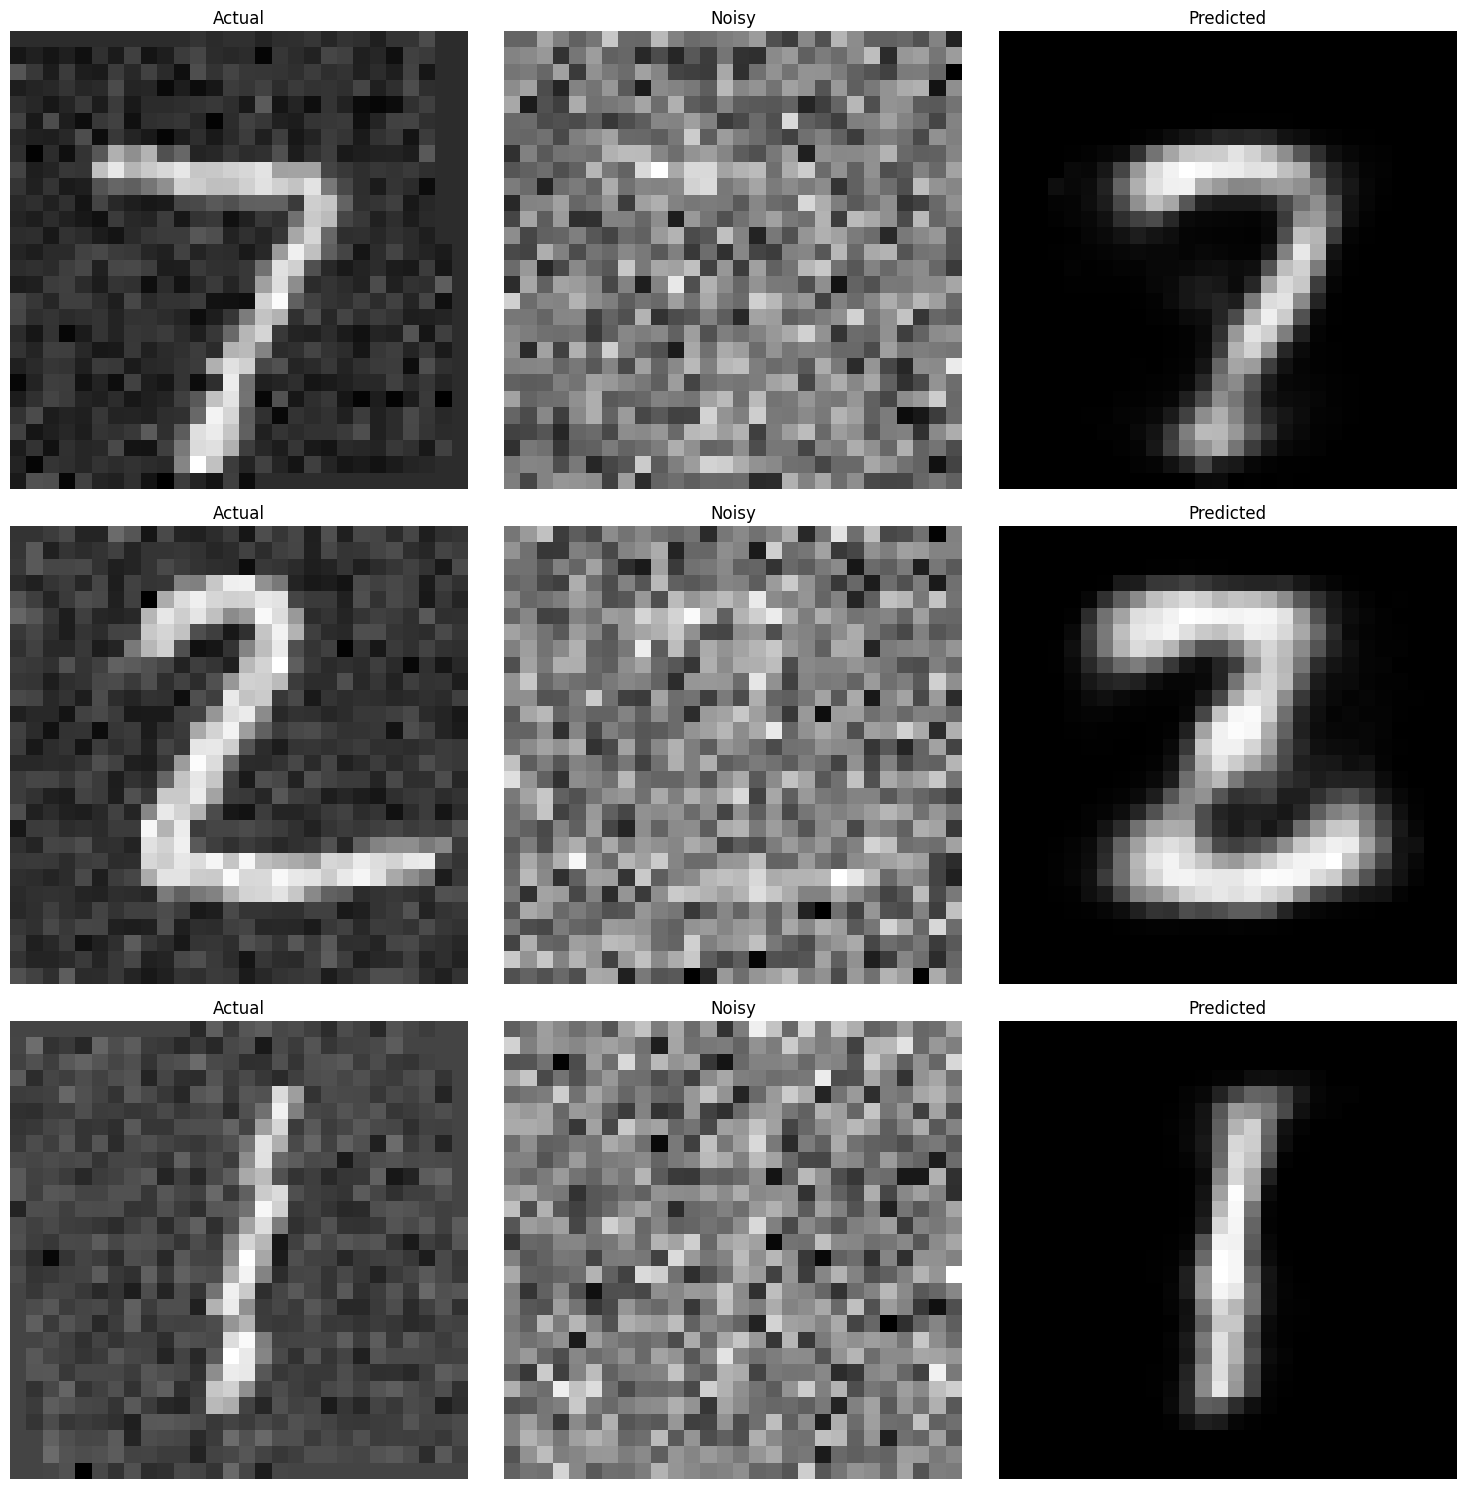

Training with bottleneck dimension = 32
Epoch 1/5, Train Loss: 0.0481
Epoch 2/5, Train Loss: 0.0471
Epoch 3/5, Train Loss: 0.0464
Epoch 4/5, Train Loss: 0.0458
Epoch 5/5, Train Loss: 0.0453
Average SSIM test score with bottleneck dimension=32: 0.5817


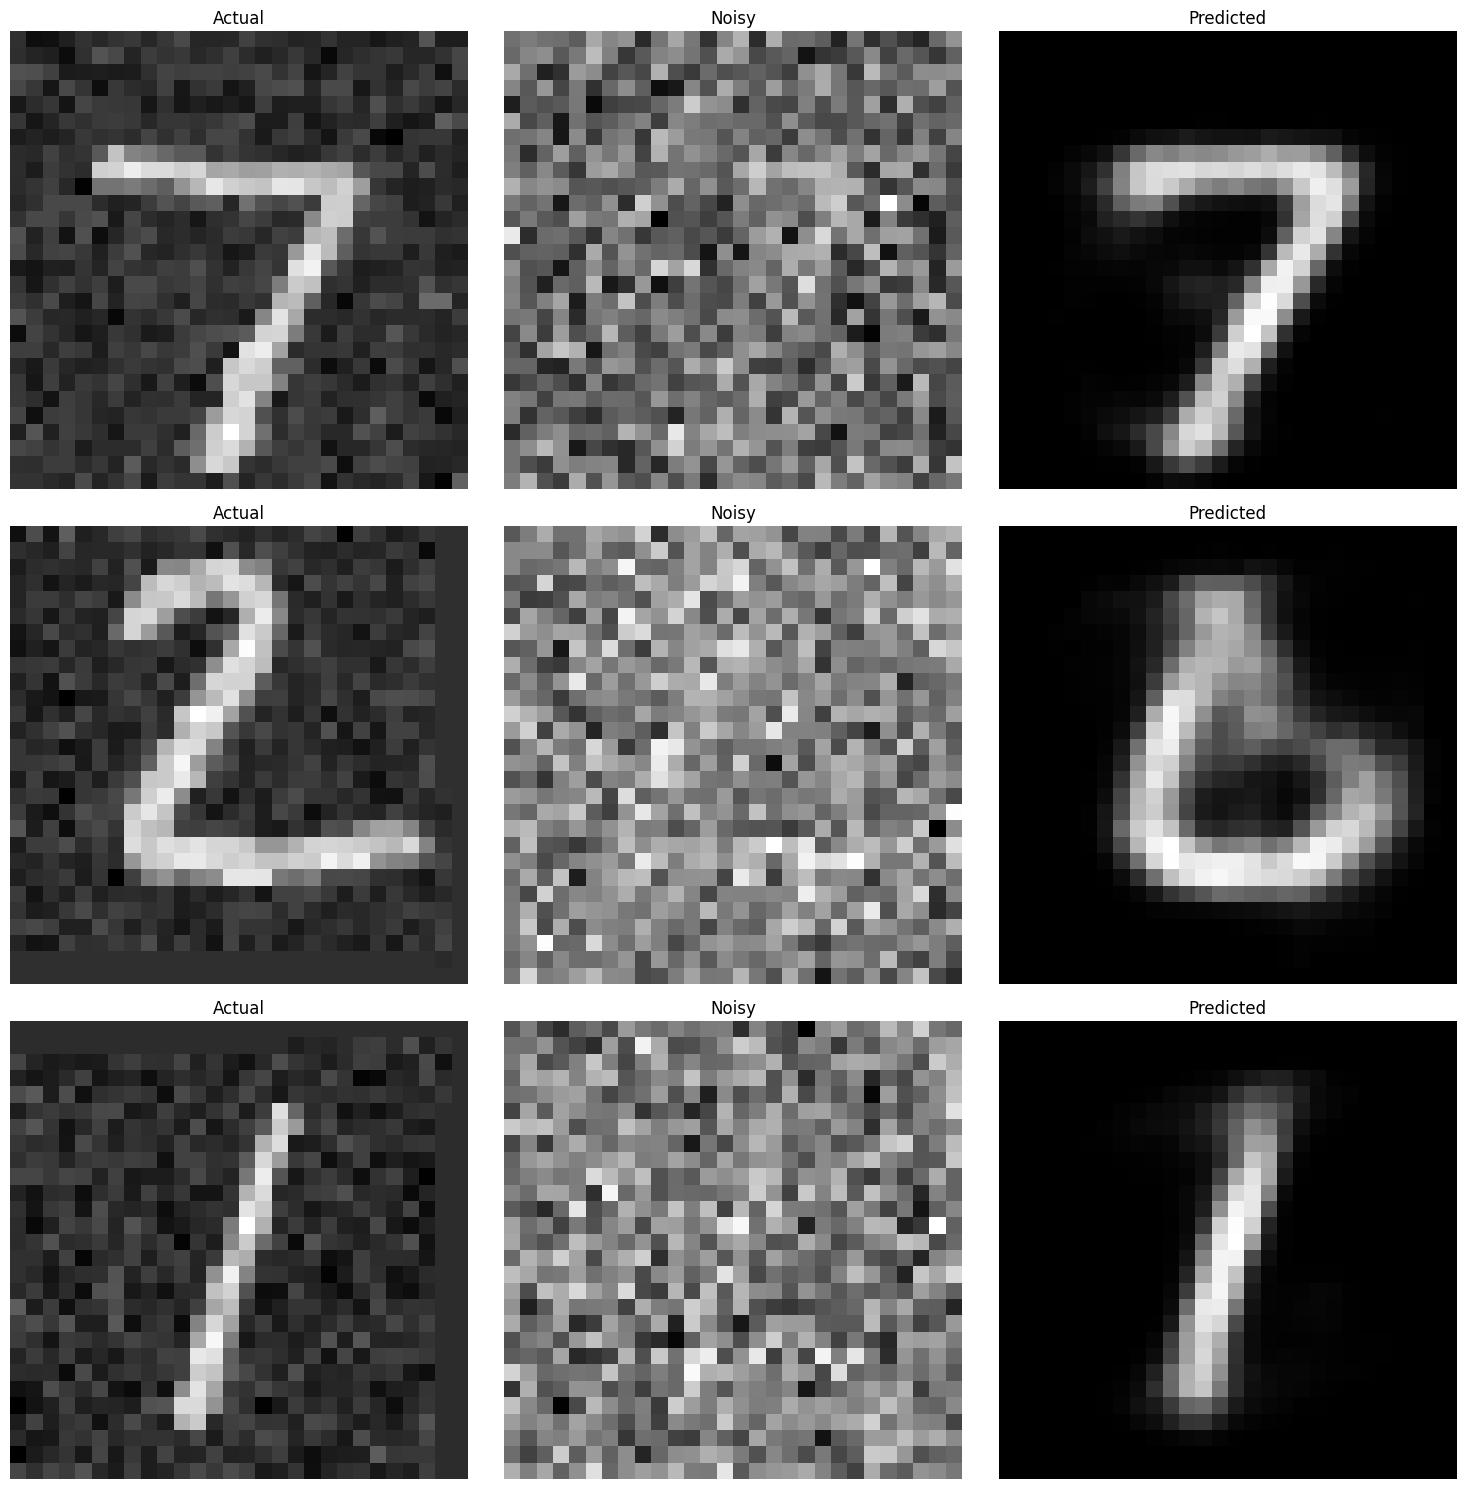

Training with bottleneck dimension = 64
Epoch 1/5, Train Loss: 0.0448
Epoch 2/5, Train Loss: 0.0444
Epoch 3/5, Train Loss: 0.0442
Epoch 4/5, Train Loss: 0.0439
Epoch 5/5, Train Loss: 0.0436
Average SSIM test score with bottleneck dimension=64: 0.6006


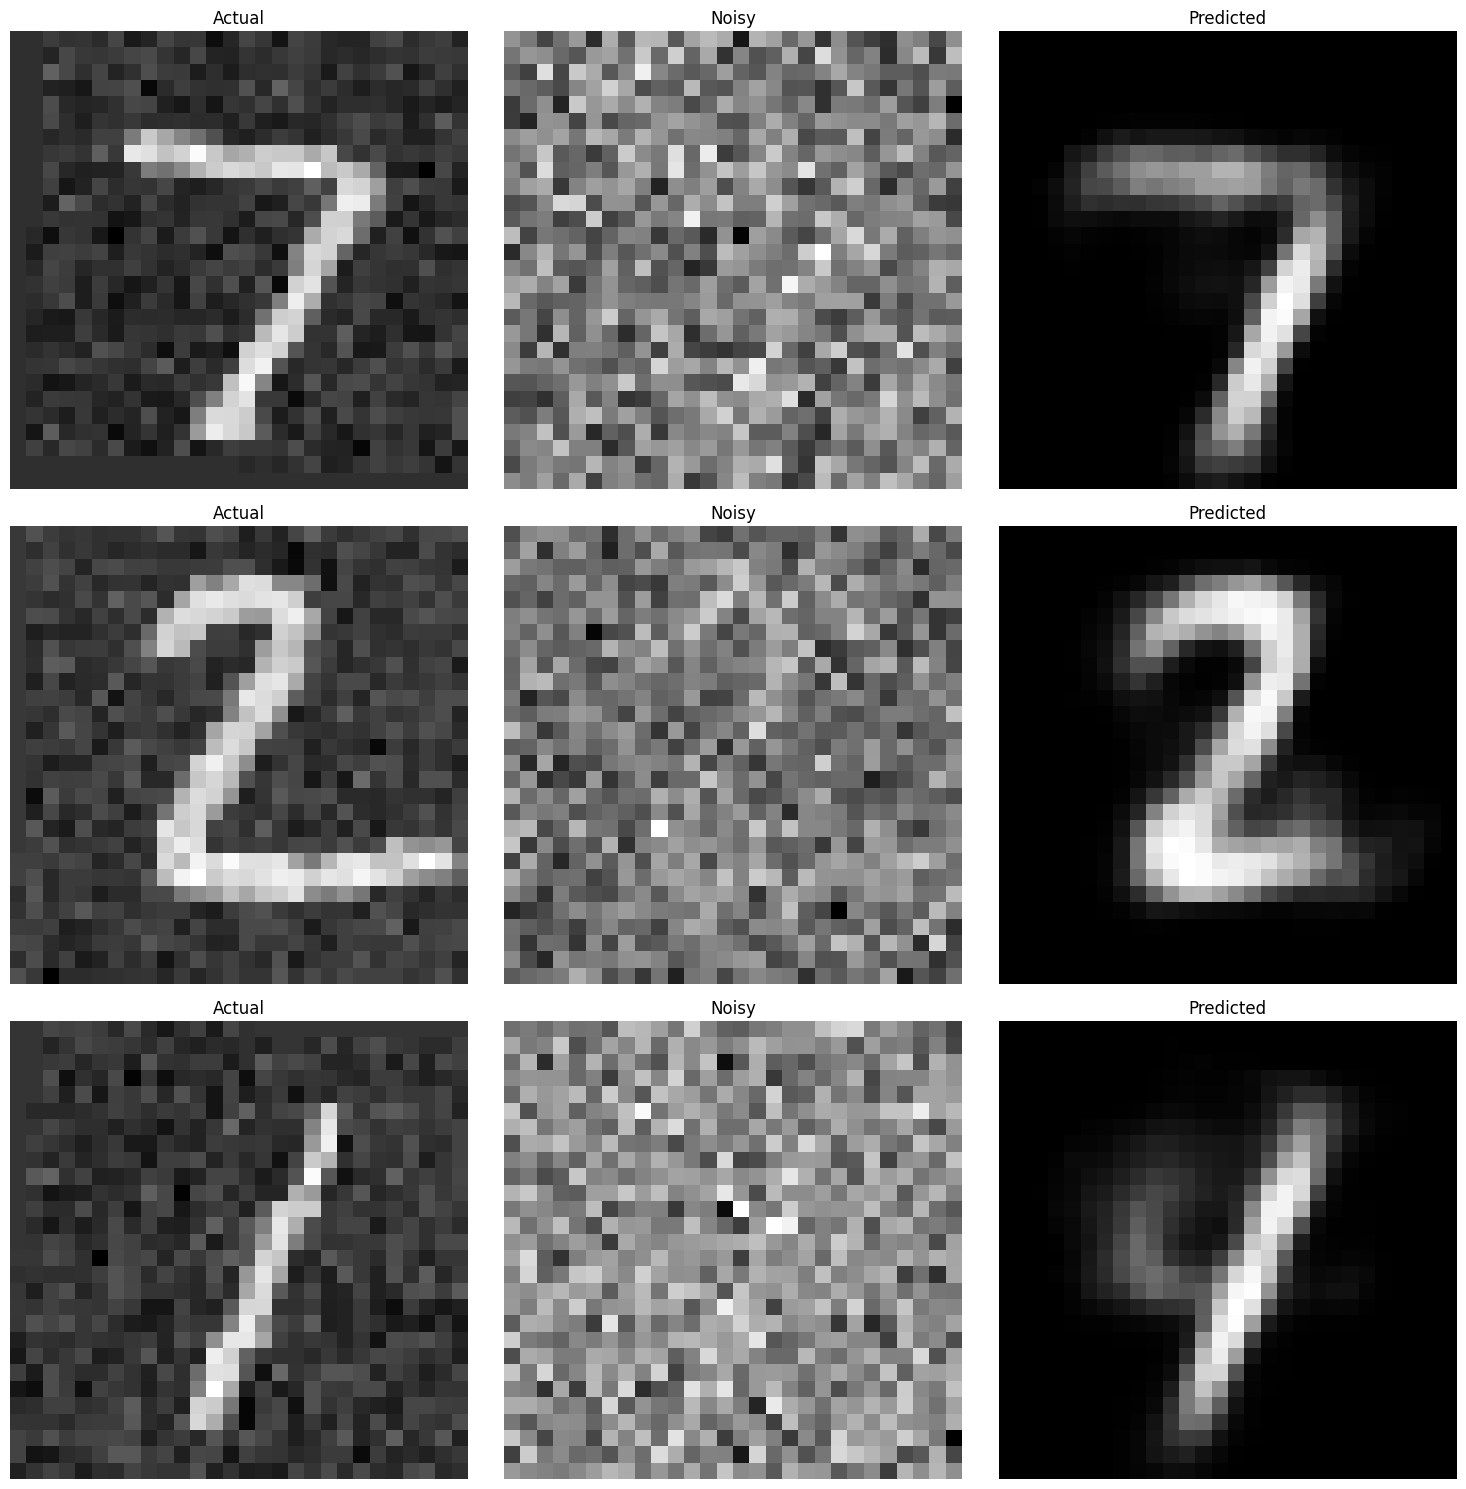

In [31]:

# Training loop
epochs = 5
sigma = 1.0  # Set sigma constant
bottleneck_dims = [16, 32, 64]  # Bottleneck dimensions for the model
ssim_scores_bottleneck = []

print(f"Training with Sigma Constant = {sigma}")

# Initialize model, criterion, optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)



for bottleneck_dim in bottleneck_dims:
    print(f"Training with bottleneck dimension = {bottleneck_dim}")
    for epoch in range(epochs):
        train_loss = train(autoencoder, criterion, optimizer, train_loader, sigma)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    test_ssim, actual_images, noisy_images, predicted_images = test(autoencoder, criterion, test_loader , sigma)
    ssim_scores_bottleneck.append(test_ssim)
    print(f"Average SSIM test score with bottleneck dimension={bottleneck_dim}: {test_ssim:.4f}")


    num_examples = 3
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 15))
    for i in range(num_examples):
        axes[i, 0].imshow(actual_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 0].set_title("Actual")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(noisy_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 1].set_title("Noisy")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predicted_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 2].set_title("Predicted")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()




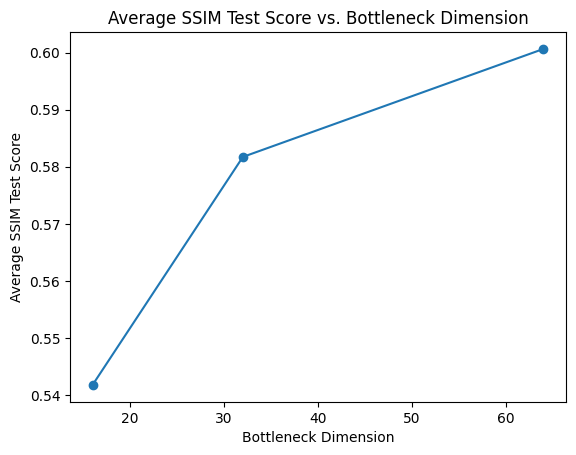

In [32]:
# Plot SSIM scores for different bottleneck dimensions
plt.plot(bottleneck_dims, ssim_scores_bottleneck, marker='o')
plt.title('Average SSIM Test Score vs. Bottleneck Dimension')
plt.xlabel('Bottleneck Dimension')
plt.ylabel('Average SSIM Test Score')
plt.show()

****ObserVation  AutoEncoder
****as the sigma values increase means noise added then ssim scores decrease coz distortion (Noise)
you can check above graph plotted
and 
for each sigma three differnet bottleneck values coz btlnk dim increase
so for each sigma
    for each bottle neck as bottle neck increase then ssim scores increases
    can check above plotted graph

**Based on the observations from the experiments with the autoencoder:
**
**Effect of Sigma on SSIM Scores:
**
As the sigma value (noise level) increases, the SSIM scores decrease. This is expected because higher levels of noise lead to more distortion in the reconstructed images, reducing their similarity to the original images.

**Effect of Bottleneck Dimension on SSIM Scores:
**
For each sigma value, as the bottleneck dimension increases, the SSIM scores increase. This indicates that a higher bottleneck dimension allows the autoencoder to capture more features and information about the input images, leading to better reconstruction quality.
Overall, these observations suggest that the performance of the autoencoder in reconstructing images is influenced by both the level of noise in the input images and the complexity (dimension) of the bottleneck layer. Lower noise levels and higher bottleneck dimensions generally lead to better reconstruction quality, as reflected in higher SSIM scores.





